In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

In [2]:
df = pd.read_pickle("data.pkl")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149855 entries, 0 to 149854
Data columns (total 86 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              149855 non-null  int64  
 1   ID                 149855 non-null  int64  
 2   S15                149855 non-null  float64
 3   S17                149855 non-null  float64
 4   S13                149855 non-null  float64
 5   S5                 149855 non-null  float64
 6   S16                149855 non-null  float64
 7   S19                149855 non-null  float64
 8   S18                149855 non-null  float64
 9   EQUIPMENT_FAILURE  149855 non-null  int64  
 10  S8                 149855 non-null  float64
 11  AGE_OF_EQUIPMENT   149855 non-null  int64  
 12  TIME_SINCE_START   149855 non-null  float64
 13  too_soon           149855 non-null  int32  
 14  S15_mean           149855 non-null  float64
 15  S17_mean           149855 non-null  float64
 16  S1

In [4]:
X = df[[x for x in df.columns if x not in ['FAILURE_TARGET','EQUIPMENT_FAILURE', 'TIME_TO_FAILURE']]]
y = df[['FAILURE_TARGET']]

In [5]:
try:
    X = X.to_numpy()
    y = y.to_numpy().ravel()
except:
    pass


In [6]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)
#Now since we want the valid and test size to be equal (10% each of overall data).
test_size = 0.5
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
def test(y_true,y_pred):
    print(accuracy_score(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print('tn',tn, 'fp',fp, 'fn',fn, 'tp',tp)
    print('f1', f1_score(y_true, y_pred))


In [9]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')
svc.fit(X_train_scaled,y_train)
y_pred = svc.predict(X_val_scaled)
test(y_val,y_pred)

0.968968968968969
[[14428     8]
 [  457    92]]
tn 14428 fp 8 fn 457 tp 92
f1 0.2835130970724192


In [13]:
from sklearn.utils import resample
X_oversampled, y_oversampled = resample(X_train_scaled[y_train == 1],
                                        y_train[y_train == 1],
                                        replace=True,
                                        n_samples=X_train_scaled[y_train == 0].shape[0])
X_balanced = np.vstack((X_train_scaled[y_train == 0], X_oversampled))
y_balanced = np.hstack((y_train[y_train == 0], y_oversampled))



In [11]:
svc_balanced = SVC(gamma='auto')
svc_balanced.fit(X_balanced[::2],y_balanced[::2])
y_pred_balanced = svc_balanced.predict(X_val_scaled)
test(y_val,y_pred_balanced)

0.8894227560894228
[[12791  1645]
 [   12   537]]
tn 12791 fp 1645 fn 12 tp 537
f1 0.3932625411937019


In [12]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_balanced,y_balanced)
y_pred_rfc = rfc.predict(X_val_scaled)
test(y_val,y_pred_rfc)

0.9960627293960628
[[14415    21]
 [   38   511]]
tn 14415 fp 21 fn 38 tp 511
f1 0.9454209065679926


In [16]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(40, 20))
nn.fit(X_balanced,y_balanced)
y_pred_nn = nn.predict(X_val_scaled)
test(y_val,y_pred_nn)

0.9882549215882549
[[14290   146]
 [   30   519]]
tn 14290 fp 146 fn 30 tp 519
f1 0.8550247116968698


In [14]:
y_pred_nn = nn.predict(X_test_scaled)
test(y_test,y_pred_nn)

0.9804484185239557
[[14126   263]
 [   30   567]]
tn 14126 fp 263 fn 30 tp 567
f1 0.7946741415557114


In [15]:
y_pred_rfc = rfc.predict(X_test_scaled)
test(y_test,y_pred_rfc)

0.9966635526491392
[[14378    11]
 [   39   558]]
tn 14378 fp 11 fn 39 tp 558
f1 0.9571183533447685


In [11]:
print(X_train_scaled.shape[1])

83


In [90]:
##NEURAL NETWORK WITH PYTORCH
n_input, n_hidden, n_out = X_train_scaled.shape[1], (40,20), 1, 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_input,n_hidden[0])
        self.fc2 = nn.Linear(n_hidden[0], n_hidden[1])
        self.fc3 = nn.Linear(n_hidden[1], n_out)
        self.ReLU = nn.ReLU()

        
    def forward(self, x):
        x = self.ReLU(self.fc1(x))
        x = self.ReLU(self.fc2(x))
        x = self.ReLU(self.fc3(x))
        x = torch.sigmoid(x)
        return torch.flatten(x)#torch.reshape(x,(1,))

model = Net()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

tensor_x = torch.Tensor(X_balanced) # transform to torch tensor
tensor_y = torch.Tensor(y_balanced)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset,batch_size=256, shuffle=True) # create your dataloader

tensor_x = torch.Tensor(X_val_scaled) # transform to torch tensor
tensor_y = torch.Tensor(y_val)
my_dataset = TensorDataset(tensor_x,tensor_y)
validation_loader = DataLoader(my_dataset,batch_size=256, shuffle=True)

In [92]:
n_epochs = 50
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(my_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(my_dataloader):
        #data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        
        #_,pred = torch.max(outputs)#, dim=1)
        pred = torch.round(outputs)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            #data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            pred_t = torch.round(outputs_t)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        #if network_learned:
        #    valid_loss_min = batch_loss
        #    torch.save(model.state_dict(), 'model_classification_tutorial.pt')
        #    print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/50], Step [0/901], Loss: 0.4748
Epoch [1/50], Step [10/901], Loss: 0.4529
Epoch [1/50], Step [20/901], Loss: 0.4562
Epoch [1/50], Step [30/901], Loss: 0.4891
Epoch [1/50], Step [40/901], Loss: 0.4871
Epoch [1/50], Step [50/901], Loss: 0.5055
Epoch [1/50], Step [60/901], Loss: 0.4604
Epoch [1/50], Step [70/901], Loss: 0.4891
Epoch [1/50], Step [80/901], Loss: 0.4749
Epoch [1/50], Step [90/901], Loss: 0.4829
Epoch [1/50], Step [100/901], Loss: 0.4584
Epoch [1/50], Step [110/901], Loss: 0.4791
Epoch [1/50], Step [120/901], Loss: 0.4678
Epoch [1/50], Step [130/901], Loss: 0.4900
Epoch [1/50], Step [140/901], Loss: 0.4601
Epoch [1/50], Step [150/901], Loss: 0.4484
Epoch [1/50], Step [160/901], Loss: 0.4581
Epoch [1/50], Step [170/901], Loss: 0.4681
Epoch [1/50], Step [180/901], Loss: 0.4245
Epoch [1/50], Step [190/901], Loss: 0.4360
Epoch [1/50], Step [200/901], Loss: 0.5490
Epoch [1/50], Step [210/901], Loss: 0.4222
Epoch [1/50], Step [220/901], Loss: 0.4585
Epoch [1/50],

Epoch [3/50], Step [110/901], Loss: 0.4733
Epoch [3/50], Step [120/901], Loss: 0.4854
Epoch [3/50], Step [130/901], Loss: 0.4830
Epoch [3/50], Step [140/901], Loss: 0.4421
Epoch [3/50], Step [150/901], Loss: 0.4635
Epoch [3/50], Step [160/901], Loss: 0.4840
Epoch [3/50], Step [170/901], Loss: 0.4605
Epoch [3/50], Step [180/901], Loss: 0.4854
Epoch [3/50], Step [190/901], Loss: 0.4442
Epoch [3/50], Step [200/901], Loss: 0.4905
Epoch [3/50], Step [210/901], Loss: 0.4401
Epoch [3/50], Step [220/901], Loss: 0.4679
Epoch [3/50], Step [230/901], Loss: 0.4473
Epoch [3/50], Step [240/901], Loss: 0.5351
Epoch [3/50], Step [250/901], Loss: 0.4518
Epoch [3/50], Step [260/901], Loss: 0.4560
Epoch [3/50], Step [270/901], Loss: 0.5060
Epoch [3/50], Step [280/901], Loss: 0.4426
Epoch [3/50], Step [290/901], Loss: 0.4562
Epoch [3/50], Step [300/901], Loss: 0.5268
Epoch [3/50], Step [310/901], Loss: 0.4224
Epoch [3/50], Step [320/901], Loss: 0.4608
Epoch [3/50], Step [330/901], Loss: 0.4834
Epoch [3/50

Epoch [5/50], Step [240/901], Loss: 0.4665
Epoch [5/50], Step [250/901], Loss: 0.4426
Epoch [5/50], Step [260/901], Loss: 0.4697
Epoch [5/50], Step [270/901], Loss: 0.4888
Epoch [5/50], Step [280/901], Loss: 0.4817
Epoch [5/50], Step [290/901], Loss: 0.4990
Epoch [5/50], Step [300/901], Loss: 0.4718
Epoch [5/50], Step [310/901], Loss: 0.4511
Epoch [5/50], Step [320/901], Loss: 0.4767
Epoch [5/50], Step [330/901], Loss: 0.4651
Epoch [5/50], Step [340/901], Loss: 0.4727
Epoch [5/50], Step [350/901], Loss: 0.4750
Epoch [5/50], Step [360/901], Loss: 0.4405
Epoch [5/50], Step [370/901], Loss: 0.5234
Epoch [5/50], Step [380/901], Loss: 0.4434
Epoch [5/50], Step [390/901], Loss: 0.4206
Epoch [5/50], Step [400/901], Loss: 0.4542
Epoch [5/50], Step [410/901], Loss: 0.4721
Epoch [5/50], Step [420/901], Loss: 0.5029
Epoch [5/50], Step [430/901], Loss: 0.4272
Epoch [5/50], Step [440/901], Loss: 0.4290
Epoch [5/50], Step [450/901], Loss: 0.4584
Epoch [5/50], Step [460/901], Loss: 0.4497
Epoch [5/50

Epoch [7/50], Step [380/901], Loss: 0.4486
Epoch [7/50], Step [390/901], Loss: 0.4726
Epoch [7/50], Step [400/901], Loss: 0.4615
Epoch [7/50], Step [410/901], Loss: 0.4656
Epoch [7/50], Step [420/901], Loss: 0.4239
Epoch [7/50], Step [430/901], Loss: 0.4402
Epoch [7/50], Step [440/901], Loss: 0.4392
Epoch [7/50], Step [450/901], Loss: 0.4644
Epoch [7/50], Step [460/901], Loss: 0.4594
Epoch [7/50], Step [470/901], Loss: 0.4275
Epoch [7/50], Step [480/901], Loss: 0.4379
Epoch [7/50], Step [490/901], Loss: 0.4471
Epoch [7/50], Step [500/901], Loss: 0.4445
Epoch [7/50], Step [510/901], Loss: 0.4759
Epoch [7/50], Step [520/901], Loss: 0.4027
Epoch [7/50], Step [530/901], Loss: 0.5723
Epoch [7/50], Step [540/901], Loss: 0.5173
Epoch [7/50], Step [550/901], Loss: 0.4918
Epoch [7/50], Step [560/901], Loss: 0.4460
Epoch [7/50], Step [570/901], Loss: 0.4081
Epoch [7/50], Step [580/901], Loss: 0.4148
Epoch [7/50], Step [590/901], Loss: 0.4390
Epoch [7/50], Step [600/901], Loss: 0.4659
Epoch [7/50

Epoch [9/50], Step [440/901], Loss: 0.4868
Epoch [9/50], Step [450/901], Loss: 0.4656
Epoch [9/50], Step [460/901], Loss: 0.4189
Epoch [9/50], Step [470/901], Loss: 0.4309
Epoch [9/50], Step [480/901], Loss: 0.4526
Epoch [9/50], Step [490/901], Loss: 0.4398
Epoch [9/50], Step [500/901], Loss: 0.4353
Epoch [9/50], Step [510/901], Loss: 0.4984
Epoch [9/50], Step [520/901], Loss: 0.4079
Epoch [9/50], Step [530/901], Loss: 0.4367
Epoch [9/50], Step [540/901], Loss: 0.4702
Epoch [9/50], Step [550/901], Loss: 0.4481
Epoch [9/50], Step [560/901], Loss: 0.4814
Epoch [9/50], Step [570/901], Loss: 0.4135
Epoch [9/50], Step [580/901], Loss: 0.4794
Epoch [9/50], Step [590/901], Loss: 0.4574
Epoch [9/50], Step [600/901], Loss: 0.4111
Epoch [9/50], Step [610/901], Loss: 0.4443
Epoch [9/50], Step [620/901], Loss: 0.4618
Epoch [9/50], Step [630/901], Loss: 0.4867
Epoch [9/50], Step [640/901], Loss: 0.4821
Epoch [9/50], Step [650/901], Loss: 0.4373
Epoch [9/50], Step [660/901], Loss: 0.4486
Epoch [9/50

Epoch [11/50], Step [540/901], Loss: 0.4755
Epoch [11/50], Step [550/901], Loss: 0.4214
Epoch [11/50], Step [560/901], Loss: 0.4420
Epoch [11/50], Step [570/901], Loss: 0.5325
Epoch [11/50], Step [580/901], Loss: 0.4406
Epoch [11/50], Step [590/901], Loss: 0.4812
Epoch [11/50], Step [600/901], Loss: 0.4973
Epoch [11/50], Step [610/901], Loss: 0.4866
Epoch [11/50], Step [620/901], Loss: 0.4680
Epoch [11/50], Step [630/901], Loss: 0.4267
Epoch [11/50], Step [640/901], Loss: 0.4570
Epoch [11/50], Step [650/901], Loss: 0.4724
Epoch [11/50], Step [660/901], Loss: 0.5304
Epoch [11/50], Step [670/901], Loss: 0.5003
Epoch [11/50], Step [680/901], Loss: 0.4230
Epoch [11/50], Step [690/901], Loss: 0.4231
Epoch [11/50], Step [700/901], Loss: 0.4660
Epoch [11/50], Step [710/901], Loss: 0.4400
Epoch [11/50], Step [720/901], Loss: 0.4422
Epoch [11/50], Step [730/901], Loss: 0.4702
Epoch [11/50], Step [740/901], Loss: 0.4496
Epoch [11/50], Step [750/901], Loss: 0.4274
Epoch [11/50], Step [760/901], L

Epoch [13/50], Step [590/901], Loss: 0.4503
Epoch [13/50], Step [600/901], Loss: 0.4969
Epoch [13/50], Step [610/901], Loss: 0.4312
Epoch [13/50], Step [620/901], Loss: 0.4697
Epoch [13/50], Step [630/901], Loss: 0.4567
Epoch [13/50], Step [640/901], Loss: 0.4469
Epoch [13/50], Step [650/901], Loss: 0.4382
Epoch [13/50], Step [660/901], Loss: 0.4319
Epoch [13/50], Step [670/901], Loss: 0.4659
Epoch [13/50], Step [680/901], Loss: 0.4512
Epoch [13/50], Step [690/901], Loss: 0.4730
Epoch [13/50], Step [700/901], Loss: 0.4388
Epoch [13/50], Step [710/901], Loss: 0.4146
Epoch [13/50], Step [720/901], Loss: 0.4583
Epoch [13/50], Step [730/901], Loss: 0.4274
Epoch [13/50], Step [740/901], Loss: 0.4128
Epoch [13/50], Step [750/901], Loss: 0.5084
Epoch [13/50], Step [760/901], Loss: 0.4807
Epoch [13/50], Step [770/901], Loss: 0.4663
Epoch [13/50], Step [780/901], Loss: 0.4770
Epoch [13/50], Step [790/901], Loss: 0.4731
Epoch [13/50], Step [800/901], Loss: 0.4642
Epoch [13/50], Step [810/901], L

Epoch [15/50], Step [650/901], Loss: 0.4575
Epoch [15/50], Step [660/901], Loss: 0.4416
Epoch [15/50], Step [670/901], Loss: 0.4479
Epoch [15/50], Step [680/901], Loss: 0.4316
Epoch [15/50], Step [690/901], Loss: 0.4079
Epoch [15/50], Step [700/901], Loss: 0.4137
Epoch [15/50], Step [710/901], Loss: 0.4364
Epoch [15/50], Step [720/901], Loss: 0.4270
Epoch [15/50], Step [730/901], Loss: 0.4449
Epoch [15/50], Step [740/901], Loss: 0.4495
Epoch [15/50], Step [750/901], Loss: 0.4858
Epoch [15/50], Step [760/901], Loss: 0.4780
Epoch [15/50], Step [770/901], Loss: 0.5020
Epoch [15/50], Step [780/901], Loss: 0.4430
Epoch [15/50], Step [790/901], Loss: 0.4593
Epoch [15/50], Step [800/901], Loss: 0.4348
Epoch [15/50], Step [810/901], Loss: 0.4771
Epoch [15/50], Step [820/901], Loss: 0.4602
Epoch [15/50], Step [830/901], Loss: 0.4687
Epoch [15/50], Step [840/901], Loss: 0.4311
Epoch [15/50], Step [850/901], Loss: 0.4169
Epoch [15/50], Step [860/901], Loss: 0.4335
Epoch [15/50], Step [870/901], L

Epoch [17/50], Step [680/901], Loss: 0.4501
Epoch [17/50], Step [690/901], Loss: 0.4598
Epoch [17/50], Step [700/901], Loss: 0.4532
Epoch [17/50], Step [710/901], Loss: 0.4283
Epoch [17/50], Step [720/901], Loss: 0.4488
Epoch [17/50], Step [730/901], Loss: 0.4327
Epoch [17/50], Step [740/901], Loss: 0.4634
Epoch [17/50], Step [750/901], Loss: 0.4291
Epoch [17/50], Step [760/901], Loss: 0.4610
Epoch [17/50], Step [770/901], Loss: 0.4573
Epoch [17/50], Step [780/901], Loss: 0.4784
Epoch [17/50], Step [790/901], Loss: 0.4182
Epoch [17/50], Step [800/901], Loss: 0.4809
Epoch [17/50], Step [810/901], Loss: 0.4900
Epoch [17/50], Step [820/901], Loss: 0.4337
Epoch [17/50], Step [830/901], Loss: 0.4679
Epoch [17/50], Step [840/901], Loss: 0.4755
Epoch [17/50], Step [850/901], Loss: 0.4429
Epoch [17/50], Step [860/901], Loss: 0.4340
Epoch [17/50], Step [870/901], Loss: 0.4800
Epoch [17/50], Step [880/901], Loss: 0.3995
Epoch [17/50], Step [890/901], Loss: 0.4424
Epoch [17/50], Step [900/901], L

Epoch [19/50], Step [730/901], Loss: 0.4800
Epoch [19/50], Step [740/901], Loss: 0.4171
Epoch [19/50], Step [750/901], Loss: 0.4751
Epoch [19/50], Step [760/901], Loss: 0.4200
Epoch [19/50], Step [770/901], Loss: 0.4280
Epoch [19/50], Step [780/901], Loss: 0.4365
Epoch [19/50], Step [790/901], Loss: 0.4475
Epoch [19/50], Step [800/901], Loss: 0.4555
Epoch [19/50], Step [810/901], Loss: 0.4315
Epoch [19/50], Step [820/901], Loss: 0.4353
Epoch [19/50], Step [830/901], Loss: 0.5086
Epoch [19/50], Step [840/901], Loss: 0.4204
Epoch [19/50], Step [850/901], Loss: 0.4603
Epoch [19/50], Step [860/901], Loss: 0.4142
Epoch [19/50], Step [870/901], Loss: 0.4365
Epoch [19/50], Step [880/901], Loss: 0.4476
Epoch [19/50], Step [890/901], Loss: 0.4177
Epoch [19/50], Step [900/901], Loss: 0.4497

train loss: 0.4540, train acc: 87.9927
validation loss: 0.7100, validation acc: 97.2105

Epoch 20

Epoch [20/50], Step [0/901], Loss: 0.4715
Epoch [20/50], Step [10/901], Loss: 0.4209
Epoch [20/50], Step [20

Epoch [21/50], Step [770/901], Loss: 0.4396
Epoch [21/50], Step [780/901], Loss: 0.4383
Epoch [21/50], Step [790/901], Loss: 0.4635
Epoch [21/50], Step [800/901], Loss: 0.4511
Epoch [21/50], Step [810/901], Loss: 0.4314
Epoch [21/50], Step [820/901], Loss: 0.4324
Epoch [21/50], Step [830/901], Loss: 0.4615
Epoch [21/50], Step [840/901], Loss: 0.4709
Epoch [21/50], Step [850/901], Loss: 0.4489
Epoch [21/50], Step [860/901], Loss: 0.4274
Epoch [21/50], Step [870/901], Loss: 0.4560
Epoch [21/50], Step [880/901], Loss: 0.4511
Epoch [21/50], Step [890/901], Loss: 0.4810
Epoch [21/50], Step [900/901], Loss: 0.4552

train loss: 0.4531, train acc: 88.1011
validation loss: 0.7096, validation acc: 97.4842

Epoch 22

Epoch [22/50], Step [0/901], Loss: 0.4085
Epoch [22/50], Step [10/901], Loss: 0.4584
Epoch [22/50], Step [20/901], Loss: 0.4180
Epoch [22/50], Step [30/901], Loss: 0.4287
Epoch [22/50], Step [40/901], Loss: 0.4549
Epoch [22/50], Step [50/901], Loss: 0.4822
Epoch [22/50], Step [60/901

Epoch [23/50], Step [860/901], Loss: 0.4428
Epoch [23/50], Step [870/901], Loss: 0.4311
Epoch [23/50], Step [880/901], Loss: 0.4289
Epoch [23/50], Step [890/901], Loss: 0.4407
Epoch [23/50], Step [900/901], Loss: 0.4830

train loss: 0.4523, train acc: 88.0881
validation loss: 0.7098, validation acc: 96.9770

Epoch 24

Epoch [24/50], Step [0/901], Loss: 0.4355
Epoch [24/50], Step [10/901], Loss: 0.4437
Epoch [24/50], Step [20/901], Loss: 0.4407
Epoch [24/50], Step [30/901], Loss: 0.3993
Epoch [24/50], Step [40/901], Loss: 0.4386
Epoch [24/50], Step [50/901], Loss: 0.3831
Epoch [24/50], Step [60/901], Loss: 0.4719
Epoch [24/50], Step [70/901], Loss: 0.4396
Epoch [24/50], Step [80/901], Loss: 0.4032
Epoch [24/50], Step [90/901], Loss: 0.4166
Epoch [24/50], Step [100/901], Loss: 0.4878
Epoch [24/50], Step [110/901], Loss: 0.4425
Epoch [24/50], Step [120/901], Loss: 0.4409
Epoch [24/50], Step [130/901], Loss: 0.4688
Epoch [24/50], Step [140/901], Loss: 0.4448
Epoch [24/50], Step [150/901], 

validation loss: 0.7088, validation acc: 97.6510

Epoch 26

Epoch [26/50], Step [0/901], Loss: 0.4525
Epoch [26/50], Step [10/901], Loss: 0.4366
Epoch [26/50], Step [20/901], Loss: 0.4139
Epoch [26/50], Step [30/901], Loss: 0.4842
Epoch [26/50], Step [40/901], Loss: 0.4232
Epoch [26/50], Step [50/901], Loss: 0.4560
Epoch [26/50], Step [60/901], Loss: 0.4168
Epoch [26/50], Step [70/901], Loss: 0.4594
Epoch [26/50], Step [80/901], Loss: 0.4260
Epoch [26/50], Step [90/901], Loss: 0.3993
Epoch [26/50], Step [100/901], Loss: 0.4376
Epoch [26/50], Step [110/901], Loss: 0.3814
Epoch [26/50], Step [120/901], Loss: 0.4475
Epoch [26/50], Step [130/901], Loss: 0.4123
Epoch [26/50], Step [140/901], Loss: 0.4362
Epoch [26/50], Step [150/901], Loss: 0.4907
Epoch [26/50], Step [160/901], Loss: 0.4345
Epoch [26/50], Step [170/901], Loss: 0.4611
Epoch [26/50], Step [180/901], Loss: 0.4806
Epoch [26/50], Step [190/901], Loss: 0.4385
Epoch [26/50], Step [200/901], Loss: 0.4671
Epoch [26/50], Step [210/90

Epoch [28/50], Step [120/901], Loss: 0.4461
Epoch [28/50], Step [130/901], Loss: 0.4403
Epoch [28/50], Step [140/901], Loss: 0.4435
Epoch [28/50], Step [150/901], Loss: 0.4572
Epoch [28/50], Step [160/901], Loss: 0.4902
Epoch [28/50], Step [170/901], Loss: 0.4660
Epoch [28/50], Step [180/901], Loss: 0.4538
Epoch [28/50], Step [190/901], Loss: 0.4419
Epoch [28/50], Step [200/901], Loss: 0.4158
Epoch [28/50], Step [210/901], Loss: 0.4031
Epoch [28/50], Step [220/901], Loss: 0.4623
Epoch [28/50], Step [230/901], Loss: 0.4664
Epoch [28/50], Step [240/901], Loss: 0.4400
Epoch [28/50], Step [250/901], Loss: 0.4533
Epoch [28/50], Step [260/901], Loss: 0.4673
Epoch [28/50], Step [270/901], Loss: 0.5166
Epoch [28/50], Step [280/901], Loss: 0.4257
Epoch [28/50], Step [290/901], Loss: 0.4354
Epoch [28/50], Step [300/901], Loss: 0.4998
Epoch [28/50], Step [310/901], Loss: 0.4478
Epoch [28/50], Step [320/901], Loss: 0.4329
Epoch [28/50], Step [330/901], Loss: 0.4410
Epoch [28/50], Step [340/901], L

Epoch [30/50], Step [240/901], Loss: 0.4526
Epoch [30/50], Step [250/901], Loss: 0.4919
Epoch [30/50], Step [260/901], Loss: 0.4383
Epoch [30/50], Step [270/901], Loss: 0.4843
Epoch [30/50], Step [280/901], Loss: 0.4273
Epoch [30/50], Step [290/901], Loss: 0.4268
Epoch [30/50], Step [300/901], Loss: 0.4407
Epoch [30/50], Step [310/901], Loss: 0.4471
Epoch [30/50], Step [320/901], Loss: 0.4424
Epoch [30/50], Step [330/901], Loss: 0.4434
Epoch [30/50], Step [340/901], Loss: 0.4682
Epoch [30/50], Step [350/901], Loss: 0.4473
Epoch [30/50], Step [360/901], Loss: 0.4412
Epoch [30/50], Step [370/901], Loss: 0.4558
Epoch [30/50], Step [380/901], Loss: 0.4013
Epoch [30/50], Step [390/901], Loss: 0.4341
Epoch [30/50], Step [400/901], Loss: 0.4057
Epoch [30/50], Step [410/901], Loss: 0.4599
Epoch [30/50], Step [420/901], Loss: 0.4224
Epoch [30/50], Step [430/901], Loss: 0.4409
Epoch [30/50], Step [440/901], Loss: 0.4652
Epoch [30/50], Step [450/901], Loss: 0.4333
Epoch [30/50], Step [460/901], L

Epoch [32/50], Step [310/901], Loss: 0.4384
Epoch [32/50], Step [320/901], Loss: 0.4746
Epoch [32/50], Step [330/901], Loss: 0.4581
Epoch [32/50], Step [340/901], Loss: 0.4395
Epoch [32/50], Step [350/901], Loss: 0.4462
Epoch [32/50], Step [360/901], Loss: 0.4158
Epoch [32/50], Step [370/901], Loss: 0.4146
Epoch [32/50], Step [380/901], Loss: 0.4178
Epoch [32/50], Step [390/901], Loss: 0.4544
Epoch [32/50], Step [400/901], Loss: 0.4437
Epoch [32/50], Step [410/901], Loss: 0.4793
Epoch [32/50], Step [420/901], Loss: 0.4588
Epoch [32/50], Step [430/901], Loss: 0.4490
Epoch [32/50], Step [440/901], Loss: 0.5046
Epoch [32/50], Step [450/901], Loss: 0.4440
Epoch [32/50], Step [460/901], Loss: 0.4235
Epoch [32/50], Step [470/901], Loss: 0.4768
Epoch [32/50], Step [480/901], Loss: 0.4501
Epoch [32/50], Step [490/901], Loss: 0.4105
Epoch [32/50], Step [500/901], Loss: 0.4738
Epoch [32/50], Step [510/901], Loss: 0.4408
Epoch [32/50], Step [520/901], Loss: 0.4348
Epoch [32/50], Step [530/901], L

Epoch [34/50], Step [380/901], Loss: 0.4264
Epoch [34/50], Step [390/901], Loss: 0.4274
Epoch [34/50], Step [400/901], Loss: 0.4078
Epoch [34/50], Step [410/901], Loss: 0.4415
Epoch [34/50], Step [420/901], Loss: 0.3879
Epoch [34/50], Step [430/901], Loss: 0.4854
Epoch [34/50], Step [440/901], Loss: 0.4400
Epoch [34/50], Step [450/901], Loss: 0.4362
Epoch [34/50], Step [460/901], Loss: 0.4535
Epoch [34/50], Step [470/901], Loss: 0.4551
Epoch [34/50], Step [480/901], Loss: 0.4544
Epoch [34/50], Step [490/901], Loss: 0.4129
Epoch [34/50], Step [500/901], Loss: 0.4539
Epoch [34/50], Step [510/901], Loss: 0.4313
Epoch [34/50], Step [520/901], Loss: 0.4346
Epoch [34/50], Step [530/901], Loss: 0.4355
Epoch [34/50], Step [540/901], Loss: 0.4495
Epoch [34/50], Step [550/901], Loss: 0.4399
Epoch [34/50], Step [560/901], Loss: 0.4152
Epoch [34/50], Step [570/901], Loss: 0.4579
Epoch [34/50], Step [580/901], Loss: 0.3994
Epoch [34/50], Step [590/901], Loss: 0.4051
Epoch [34/50], Step [600/901], L

Epoch [36/50], Step [500/901], Loss: 0.4331
Epoch [36/50], Step [510/901], Loss: 0.4719
Epoch [36/50], Step [520/901], Loss: 0.4145
Epoch [36/50], Step [530/901], Loss: 0.4101
Epoch [36/50], Step [540/901], Loss: 0.4465
Epoch [36/50], Step [550/901], Loss: 0.4198
Epoch [36/50], Step [560/901], Loss: 0.4522
Epoch [36/50], Step [570/901], Loss: 0.4103
Epoch [36/50], Step [580/901], Loss: 0.4678
Epoch [36/50], Step [590/901], Loss: 0.4040
Epoch [36/50], Step [600/901], Loss: 0.4187
Epoch [36/50], Step [610/901], Loss: 0.4115
Epoch [36/50], Step [620/901], Loss: 0.4374
Epoch [36/50], Step [630/901], Loss: 0.4417
Epoch [36/50], Step [640/901], Loss: 0.4092
Epoch [36/50], Step [650/901], Loss: 0.4523
Epoch [36/50], Step [660/901], Loss: 0.4200
Epoch [36/50], Step [670/901], Loss: 0.4289
Epoch [36/50], Step [680/901], Loss: 0.4183
Epoch [36/50], Step [690/901], Loss: 0.4301
Epoch [36/50], Step [700/901], Loss: 0.4740
Epoch [36/50], Step [710/901], Loss: 0.4439
Epoch [36/50], Step [720/901], L

Epoch [38/50], Step [590/901], Loss: 0.4510
Epoch [38/50], Step [600/901], Loss: 0.4519
Epoch [38/50], Step [610/901], Loss: 0.4087
Epoch [38/50], Step [620/901], Loss: 0.4648
Epoch [38/50], Step [630/901], Loss: 0.4652
Epoch [38/50], Step [640/901], Loss: 0.4654
Epoch [38/50], Step [650/901], Loss: 0.4404
Epoch [38/50], Step [660/901], Loss: 0.4111
Epoch [38/50], Step [670/901], Loss: 0.4015
Epoch [38/50], Step [680/901], Loss: 0.4329
Epoch [38/50], Step [690/901], Loss: 0.4290
Epoch [38/50], Step [700/901], Loss: 0.4423
Epoch [38/50], Step [710/901], Loss: 0.4310
Epoch [38/50], Step [720/901], Loss: 0.4354
Epoch [38/50], Step [730/901], Loss: 0.4528
Epoch [38/50], Step [740/901], Loss: 0.4350
Epoch [38/50], Step [750/901], Loss: 0.4279
Epoch [38/50], Step [760/901], Loss: 0.3944
Epoch [38/50], Step [770/901], Loss: 0.4241
Epoch [38/50], Step [780/901], Loss: 0.4184
Epoch [38/50], Step [790/901], Loss: 0.4398
Epoch [38/50], Step [800/901], Loss: 0.4647
Epoch [38/50], Step [810/901], L

Epoch [40/50], Step [620/901], Loss: 0.4492
Epoch [40/50], Step [630/901], Loss: 0.4443
Epoch [40/50], Step [640/901], Loss: 0.4330
Epoch [40/50], Step [650/901], Loss: 0.4146
Epoch [40/50], Step [660/901], Loss: 0.4237
Epoch [40/50], Step [670/901], Loss: 0.4308
Epoch [40/50], Step [680/901], Loss: 0.4483
Epoch [40/50], Step [690/901], Loss: 0.4594
Epoch [40/50], Step [700/901], Loss: 0.4600
Epoch [40/50], Step [710/901], Loss: 0.4248
Epoch [40/50], Step [720/901], Loss: 0.4223
Epoch [40/50], Step [730/901], Loss: 0.4392
Epoch [40/50], Step [740/901], Loss: 0.4520
Epoch [40/50], Step [750/901], Loss: 0.4271
Epoch [40/50], Step [760/901], Loss: 0.4229
Epoch [40/50], Step [770/901], Loss: 0.4368
Epoch [40/50], Step [780/901], Loss: 0.4366
Epoch [40/50], Step [790/901], Loss: 0.4427
Epoch [40/50], Step [800/901], Loss: 0.4472
Epoch [40/50], Step [810/901], Loss: 0.4345
Epoch [40/50], Step [820/901], Loss: 0.4456
Epoch [40/50], Step [830/901], Loss: 0.4482
Epoch [40/50], Step [840/901], L

Epoch [42/50], Step [630/901], Loss: 0.4219
Epoch [42/50], Step [640/901], Loss: 0.4100
Epoch [42/50], Step [650/901], Loss: 0.4661
Epoch [42/50], Step [660/901], Loss: 0.3899
Epoch [42/50], Step [670/901], Loss: 0.3950
Epoch [42/50], Step [680/901], Loss: 0.4670
Epoch [42/50], Step [690/901], Loss: 0.4429
Epoch [42/50], Step [700/901], Loss: 0.4710
Epoch [42/50], Step [710/901], Loss: 0.4239
Epoch [42/50], Step [720/901], Loss: 0.4362
Epoch [42/50], Step [730/901], Loss: 0.4672
Epoch [42/50], Step [740/901], Loss: 0.4548
Epoch [42/50], Step [750/901], Loss: 0.4133
Epoch [42/50], Step [760/901], Loss: 0.4833
Epoch [42/50], Step [770/901], Loss: 0.4473
Epoch [42/50], Step [780/901], Loss: 0.4082
Epoch [42/50], Step [790/901], Loss: 0.4581
Epoch [42/50], Step [800/901], Loss: 0.4657
Epoch [42/50], Step [810/901], Loss: 0.4681
Epoch [42/50], Step [820/901], Loss: 0.4329
Epoch [42/50], Step [830/901], Loss: 0.4359
Epoch [42/50], Step [840/901], Loss: 0.4444
Epoch [42/50], Step [850/901], L

Epoch [44/50], Step [660/901], Loss: 0.4672
Epoch [44/50], Step [670/901], Loss: 0.4337
Epoch [44/50], Step [680/901], Loss: 0.4631
Epoch [44/50], Step [690/901], Loss: 0.4283
Epoch [44/50], Step [700/901], Loss: 0.4344
Epoch [44/50], Step [710/901], Loss: 0.4872
Epoch [44/50], Step [720/901], Loss: 0.4515
Epoch [44/50], Step [730/901], Loss: 0.4489
Epoch [44/50], Step [740/901], Loss: 0.4974
Epoch [44/50], Step [750/901], Loss: 0.4310
Epoch [44/50], Step [760/901], Loss: 0.4166
Epoch [44/50], Step [770/901], Loss: 0.4106
Epoch [44/50], Step [780/901], Loss: 0.4890
Epoch [44/50], Step [790/901], Loss: 0.4327
Epoch [44/50], Step [800/901], Loss: 0.4610
Epoch [44/50], Step [810/901], Loss: 0.4484
Epoch [44/50], Step [820/901], Loss: 0.4246
Epoch [44/50], Step [830/901], Loss: 0.5327
Epoch [44/50], Step [840/901], Loss: 0.4776
Epoch [44/50], Step [850/901], Loss: 0.4320
Epoch [44/50], Step [860/901], Loss: 0.4439
Epoch [44/50], Step [870/901], Loss: 0.4377
Epoch [44/50], Step [880/901], L

Epoch [46/50], Step [770/901], Loss: 0.4136
Epoch [46/50], Step [780/901], Loss: 0.4622
Epoch [46/50], Step [790/901], Loss: 0.4236
Epoch [46/50], Step [800/901], Loss: 0.4344
Epoch [46/50], Step [810/901], Loss: 0.4371
Epoch [46/50], Step [820/901], Loss: 0.4297
Epoch [46/50], Step [830/901], Loss: 0.4049
Epoch [46/50], Step [840/901], Loss: 0.4178
Epoch [46/50], Step [850/901], Loss: 0.4226
Epoch [46/50], Step [860/901], Loss: 0.4271
Epoch [46/50], Step [870/901], Loss: 0.4334
Epoch [46/50], Step [880/901], Loss: 0.4693
Epoch [46/50], Step [890/901], Loss: 0.4725
Epoch [46/50], Step [900/901], Loss: 0.4387

train loss: 0.4460, train acc: 88.5260
validation loss: 0.7042, validation acc: 97.8512

Epoch 47

Epoch [47/50], Step [0/901], Loss: 0.4273
Epoch [47/50], Step [10/901], Loss: 0.4540
Epoch [47/50], Step [20/901], Loss: 0.4111
Epoch [47/50], Step [30/901], Loss: 0.4712
Epoch [47/50], Step [40/901], Loss: 0.4139
Epoch [47/50], Step [50/901], Loss: 0.4358
Epoch [47/50], Step [60/901

Epoch [48/50], Step [790/901], Loss: 0.4257
Epoch [48/50], Step [800/901], Loss: 0.4567
Epoch [48/50], Step [810/901], Loss: 0.4243
Epoch [48/50], Step [820/901], Loss: 0.4463
Epoch [48/50], Step [830/901], Loss: 0.4246
Epoch [48/50], Step [840/901], Loss: 0.4125
Epoch [48/50], Step [850/901], Loss: 0.4540
Epoch [48/50], Step [860/901], Loss: 0.4435
Epoch [48/50], Step [870/901], Loss: 0.4506
Epoch [48/50], Step [880/901], Loss: 0.4444
Epoch [48/50], Step [890/901], Loss: 0.3926
Epoch [48/50], Step [900/901], Loss: 0.4014

train loss: 0.4456, train acc: 88.6262
validation loss: 0.7043, validation acc: 97.6710

Epoch 49

Epoch [49/50], Step [0/901], Loss: 0.4052
Epoch [49/50], Step [10/901], Loss: 0.4504
Epoch [49/50], Step [20/901], Loss: 0.4416
Epoch [49/50], Step [30/901], Loss: 0.4179
Epoch [49/50], Step [40/901], Loss: 0.4318
Epoch [49/50], Step [50/901], Loss: 0.4277
Epoch [49/50], Step [60/901], Loss: 0.4285
Epoch [49/50], Step [70/901], Loss: 0.4202
Epoch [49/50], Step [80/901],

Epoch [50/50], Step [850/901], Loss: 0.4320
Epoch [50/50], Step [860/901], Loss: 0.4927
Epoch [50/50], Step [870/901], Loss: 0.4439
Epoch [50/50], Step [880/901], Loss: 0.4528
Epoch [50/50], Step [890/901], Loss: 0.4533
Epoch [50/50], Step [900/901], Loss: 0.4561

train loss: 0.4452, train acc: 88.7922
validation loss: 0.7042, validation acc: 97.9580



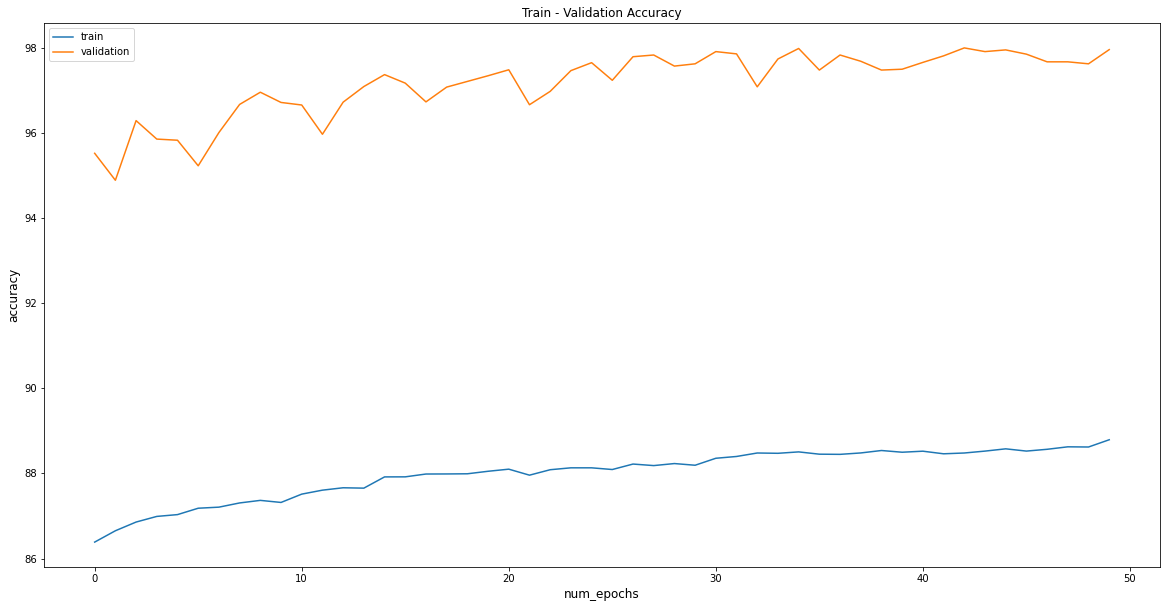

In [93]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
